# Functional Encryption - Classification and information leakage
 

### Purpose

We want to train the model on the following task: given two images with the same character, but with two different fonts, can an adversarial model guess with a good accuracy which image has been selected by a challenger which only expose the output of the private model fed with a chosen image?

We would know train the CL model to address this specific detection task. What we notice is that the training must be specific to the pair of fonts to distinguish but does not depend on the character. As there are N_FONT*(N_FONT -1)/2 = 10 possibilities of pairings, we should do 10 different trainings. We'll first try on one specific which is of medium difficulty and the expected output will be a two-neuron output. In particular we would like to show that we can perform transfer learning from the model learned to predict fonts in general to this distinguisher, which will have the same structure except a last N_FONT -> 2 Linear layer. This will help us to do our 10 models without retraining everything from scratch.

## 1. Parameters and imports


We will use the code directly from the repo, to make the notebook more readable. Functions are similar to those presented earlier.

In [1]:
# Allow to load packages from parent
import sys, os
sys.path.insert(1, os.path.realpath(os.path.pardir))

In [2]:
import random

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as utils

import learn
from learn import load_data, show_results

In [3]:
torch.set_num_threads(4)

In [4]:
class Parser:
    """Parameters for the training"""
    def __init__(self):
        self.epochs = 10
        self.sabotage_epochs = 10
        self.new_adversary_epochs = 10
        self.distinguisher_epochs = 10
        self.lr = 0.002
        self.momentum = 0.5
        self.test_batch_size = 1000
        self.batch_size = 64
        self.log_interval = 100

Some utility functions

In [5]:
def build_tensor_dataset(data, target):
    """Utility function to cast our data into a normalized torch TensorDataset"""
    normed_data = [(d - d.mean()) / d.std() for d in data]
    normed_data = torch.stack([torch.Tensor(d).reshape(1, 28, 28) for d in normed_data])
    target = torch.LongTensor([[i[0][0], i[1][0]] for i in target])
    tensor_dataset = utils.TensorDataset(normed_data, target)
    return tensor_dataset


def get_datasets():
    data = load_data()
    train_data, train_target_char, train_target_family, test_data, test_target_char, test_target_family = data
    # Merge the target datasets
    train_target = list(zip(train_target_char, train_target_family))
    test_target = list(zip(test_target_char, test_target_family))

    # We use here the slightly modified version of this function
    train_dataset = build_tensor_dataset(train_data, train_target)
    test_dataset = build_tensor_dataset(test_data, test_target)
    
    return train_dataset, test_dataset

def get_data_loaders():
    torch.manual_seed(1)
    args = Parser()

    train_dataset, test_dataset = get_datasets()

    train_loader = utils.DataLoader(
        train_dataset,
        batch_size=args.batch_size, shuffle=True
    )

    test_loader = utils.DataLoader(
        test_dataset,
        batch_size=args.test_batch_size, shuffle=True
    )
    return train_loader, test_loader

## 2. Building resistance

Let's define the model with the describes architecture. Basically you have 3 blocs: 1 quadratic and 2 CNN.

In [6]:
N_CHARS = 26
N_FONTS = 5
class QuadConvNet(nn.Module):
    def __init__(self):
        super(QuadConvNet, self).__init__()
        self.proj1 = nn.Linear(784, 50)
        self.diag1 = nn.Linear(50, 8)
        
        # --- FFN for characters
        self.lin1 = nn.Linear(8, 16)
        self.lin2 = nn.Linear(16, N_CHARS)
        
        # --- Junction
        self.jct = nn.Linear(8, 784)
        
        # --- CNN for families
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, N_FONTS)

    def quad(self, x):
        """Same as forward up to the junction part
        Used for the collateral training"""
        # --- Quadratic 
        x = x.view(-1, 784)
        x = self.proj1(x)
        x = x * x
        x = self.diag1(x)
        return x
    
    def conv_char(self, x):
        # --- FFN
        x = F.relu(self.lin1(x))
        x = self.lin2(x)
        return x
        
    def conv_font(self, x):
        # --- Junction
        x = self.jct(x)
        x = x.view(-1, 1, 28, 28)
        
        # --- CNN
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def forward_char(self, x):
        x = self.quad(x)
        x = self.conv_char(x)
        return F.log_softmax(x, dim=1)
    
    def forward_font(self, x):
        x = self.quad(x)
        x = self.conv_font(x)
        return F.log_softmax(x, dim=1)
    
    def get_params(self, net):
        """Select the params for a given part of the net"""
        if net == 'quad':
            layers = [self.proj1, self.diag1]
        elif net == 'char':
            layers = [self.lin1, self.lin2]
        elif net == 'font':
            layers = [self.jct, self.fc1, self.fc2, self.conv1, self.conv2]
        else:
            raise AttributeError(f'{net} type not recognized')
        params = [p for layer in layers for p in layer.parameters()]
        return params
    
    def freeze(self, net):
        """Freeze a part of the net"""
        net_params = self.get_params(net)
        for param in net_params:
            param.requires_grad = False
            
    def unfreeze(self):
        """Unfreeze the net"""
        for param in self.parameters():
            param.requires_grad = True
        
        

Next, we define the train and test functions. They assume the train_load return two labels: the char and the font of some input.

In the training phase we execute the 3 steps as described aboved.

In the test function, we just test the performance for the main and collateral tasks.

In [7]:
import torch

In [8]:
def train(args, model, train_loader, optimizer, epoch, alpha, initial_phase, perturbate, new_collateral):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # Split the two targets
        target_char = target[:, 0]
        target_font = target[:, 1]
        
        
        # Phase 1
        if initial_phase: # Optimise Q + C
            optimizer.zero_grad()
            output = model.forward_char(data)
            loss_char = F.nll_loss(output, target_char)
            loss_char.backward()
            optimizer.step()
        elif perturbate: # Optimise Freezed(Q) + C
            model.freeze('quad')
            optimizer.zero_grad()
            output_char = model.forward_char(data)
            loss_char = F.nll_loss(output_char, target_char)
            loss_char.backward()
            optimizer.step()
            model.unfreeze()
            
        # Phase 2
        if (initial_phase or perturbate): # Optimise Freezed(Q) + F
            model.freeze('quad')
            output_font = model.forward_font(data)
            loss_font = F.nll_loss(output_font, target_font)
            loss_font.backward()
            optimizer.step()
            model.unfreeze()
        elif new_collateral: # Optimise Freezed(Q) + new F
            model.freeze('quad')
            optimizer.zero_grad()
            output_font = model.forward_adv_font(data)
            loss_font = F.nll_loss(output_font, target_font)
            loss_font.backward()
            optimizer.step()
            model.unfreeze()
            
        # Phase 3
        if perturbate: # Optimize Q
            model.freeze('font')
            model.freeze('char')
            optimizer.zero_grad()
            output_char = model.forward_char(data)
            loss_char = F.nll_loss(output_char, target_char)

            output_font = model.forward_font(data)
            loss_font = F.nll_loss(output_font, target_font)

            loss = loss_char - alpha * loss_font
            loss.backward()
            optimizer.step()
            model.unfreeze()
            
            
        if new_collateral:
            loss_char = torch.zeros(1)
        
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss Char: {:.6f} Loss Font: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), loss_char.item(), loss_font.item()))

In [33]:
def test(args, model, test_loader, new_adversary):
    model.eval()
    correct_char = 0
    correct_font = 0
    with torch.no_grad():
        for data, target in test_loader:
            # Split the two targets
            target_char = target[:, 0]
            target_font = target[:, 1]

            # Char evaluation
            if not new_adversary:
                output = model.forward_char(data)
                pred = output.argmax(1, keepdim=True)
                correct_char += pred.eq(target_char.view_as(pred)).sum().item()
            
            # Font evaluation
            if not new_adversary:
                output = model.forward_font(data)
            else:
                output = model.forward_adv_font(data)
            pred = output.argmax(1, keepdim=True)
            correct_font += pred.eq(target_font.view_as(pred)).sum().item()

    acc_char = 100. * correct_char / len(test_loader.dataset)
    acc_font = 100. * correct_font / len(test_loader.dataset)
    print('\nTest set: Accuracy Char : {}/{} ({:.2f}%)\n          Accuracy Font : {}/{} ({:.2f}%)'.format(
        correct_char, len(test_loader.dataset), acc_char, correct_font, len(test_loader.dataset), acc_font))

    return acc_char, acc_font

In [10]:
def build_resistance(model, alpha=0):
    """
    Perform a learning + a sabotage phase
    """
    args = Parser()
    
    train_loader, test_loader = get_data_loaders()

    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
    
    test_perfs_char = []
    test_perfs_font = []
    
    for epoch in range(1, args.epochs + args.sabotage_epochs + 1):
        initial_phase = epoch <= args.epochs
        if initial_phase:
            print("(initial phase)")
        perturbate = epoch > args.epochs and epoch <= args.epochs + args.sabotage_epochs
        if perturbate:
            print("(perturbate)")
        new_adversary = False
        
        train(args, model, train_loader, optimizer, epoch, alpha, initial_phase, perturbate, new_adversary)
        test_perf_char, test_perf_font = test(args, model, test_loader, new_adversary)
        test_perfs_char.append(test_perf_char)
        test_perfs_font.append(test_perf_font)

    return test_perfs_char, test_perfs_font

In [11]:
path = '../data/models/quadconvnet_part17.pt'
model = QuadConvNet()
results = {}

try:
    model.load_state_dict(torch.load(path))
    model.eval()
    print('Model loaded!')
except FileNotFoundError:
    print('Computing model...')
    alpha=1.5
    test_perfs_char_perturbate, test_perfs_font_perturbate = build_resistance(model, alpha=alpha)
    results[f"Main task with perturbation alpha={alpha}"] = test_perfs_char_perturbate
    results[f"Collateral task with perturbation alpha={alpha}"] = test_perfs_font_perturbate
    
    model.results = results
    # save model
    torch.save(model.state_dict(), path)

Model loaded!


# 3. Testing distinguishability

In [12]:
quadratic_model = model
quadratic_model.freeze('quad')

In [13]:
def evaluate_resistance(model, alpha=0):
    """
    Perform a learning phase for the CL model
    """
    args = Parser()
    
    train_loader, test_loader = get_data_loaders()

    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
    
    test_perfs_char = []
    test_perfs_font = []
    
    for epoch in range(1, args.new_adversary_epochs + 1):
        initial_phase = False
        perturbate = False
        new_adversary = True
        
        train(args, model, train_loader, optimizer, epoch, alpha, initial_phase, perturbate, new_adversary)
        test_perf_char, test_perf_font = test(args, model, test_loader, new_adversary)
        test_perfs_char.append(test_perf_char)
        test_perfs_font.append(test_perf_font)

    return test_perfs_char, test_perfs_font

In [14]:
class BaseNet(nn.Module):
    def __init__(self, quadratic_model):
        super(BaseNet, self).__init__()
        self.proj1 = quadratic_model.proj1
        self.diag1 = quadratic_model.diag1
        
        # --- distinguisher
        self.fc3 = nn.Linear(N_FONTS, 2)
        
    def quad(self, x):
        """Same as forward up to the junction part
        Used for the collateral training"""
        # --- Quadratic 
        x = x.view(-1, 784)
        x = self.proj1(x)
        x = x * x
        x = self.diag1(x)
        return x
    
    def conv_font(self, x):
        pass
    
    def forward_adv_font(self, x):
        x = self.quad(x)
        x = self.conv_font(x)
        return F.log_softmax(x, dim=1)
        
    def forward_distinguisher(self, x):
        x = self.quad(x)
        x = self.conv_font(x)
        x = F.relu(x)
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)
        
    def get_params(self, net):
        """Select the params for a given part of the net"""
        if net == 'quad':
            layers = [self.proj1, self.diag1]
        else:
            raise AttributeError(f'{net} type not recognized')
        params = [p for layer in layers for p in layer.parameters()]
        return params
    
    def freeze(self, net):
        """Freeze a part of the net"""
        net_params = self.get_params(net)
        for param in net_params:
            param.requires_grad = False
            
    def unfreeze(self):
        """Unfreeze the net"""
        for param in self.parameters():
            param.requires_grad = True

In [15]:
resistance_reports = {}

## 3.1 Fully connected models 

In [16]:
class FFNet(BaseNet):
    def __init__(self, architecture, quadratic_model):
        super(FFNet, self).__init__(quadratic_model)
        # --- FFNs for font families
        self.architecture = architecture
        n_layer = len(architecture) + 1
        input_size = 8
        for i_layer, output_size in enumerate(architecture):
            setattr(self, f"net_{i_layer}", nn.Linear(input_size, output_size))
            input_size = output_size
        setattr(self, f"net_{n_layer}", nn.Linear(input_size, N_FONTS)) 
    
    def conv_font(self, x):
        # --- FFN
        architecture = self.architecture
        n_layer = len(architecture) + 1
        for i_layer, output_size in enumerate(architecture):
            linear = getattr(self, f"net_{i_layer}")
            x = F.relu(linear(x))
        linear = getattr(self, f"net_{n_layer}")  
        x = linear(x)
        return x
        
        

### General font detection training

Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 7.323971
Train Epoch: 1 [6400/60000 (11%)]	Loss Char: 0.000000 Loss Font: 1.804797
Train Epoch: 1 [12800/60000 (21%)]	Loss Char: 0.000000 Loss Font: 1.629145
Train Epoch: 1 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 1.697983
Train Epoch: 1 [25600/60000 (43%)]	Loss Char: 0.000000 Loss Font: 1.615380
Train Epoch: 1 [32000/60000 (53%)]	Loss Char: 0.000000 Loss Font: 1.617647
Train Epoch: 1 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 1.584459
Train Epoch: 1 [44800/60000 (75%)]	Loss Char: 0.000000 Loss Font: 1.522698
Train Epoch: 1 [51200/60000 (85%)]	Loss Char: 0.000000 Loss Font: 1.622670
Train Epoch: 1 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 1.601107

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 2607/10000 (26.07%)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 1.583823
Train Epoch: 2 [6400/60000 (11%)]	Loss Char: 0.

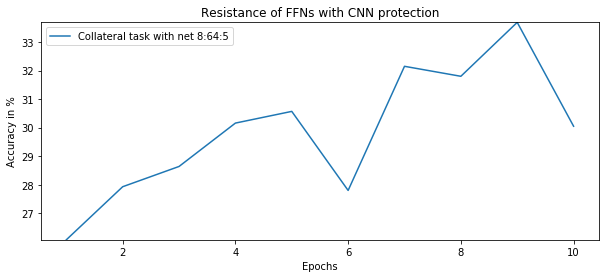

In [17]:
architectures = [[64]]

model = None 
for architecture in architectures:
    model = FFNet(architecture, quadratic_model)
    _, test_perfs_font = evaluate_resistance(model)
    
    architecture = ':'.join(map(str, [8] + architecture + [N_FONTS]))
    resistance_reports[f"Collateral task with net {architecture}"] = test_perfs_font
    
show_results(resistance_reports, title="Resistance of FFNs with CNN protection")


In [18]:
train_dataset, test_dataset = get_datasets()

Training set 60000 items
Testing set  10000 items


### Distinguisher training

Let's update the dataloader and dataset building functions to filter the fonts we want to keep

In [19]:
def build_tensor_dataset_dist(data, target, fonts):
    """Utility function to cast our data into a normalized torch TensorDataset"""
    normed_data = [(d - d.mean()) / d.std() for d in data]
    target = [[i[0][0], i[1][0]] for i in target]
    
    normed_data_filtered, target_filtered = [], []
    for data_item, target_item in zip(normed_data, target):
        if target_item[1] in fonts:
            normed_data_filtered.append(data_item)
            target_filtered.append(target_item)
    normed_data = normed_data_filtered
    target = target_filtered
    
    normed_data = torch.stack([torch.Tensor(d).reshape(1, 28, 28) for d in normed_data])
    target = torch.LongTensor(target)
    tensor_dataset = utils.TensorDataset(normed_data, target)
    return tensor_dataset


def get_datasets_dist(fonts):
    data = load_data()
    train_data, train_target_char, train_target_family, test_data, test_target_char, test_target_family = data
    # Merge the target datasets
    train_target = list(zip(train_target_char, train_target_family))
    test_target = list(zip(test_target_char, test_target_family))

    # We use here the slightly modified version of this function
    train_dataset = build_tensor_dataset_dist(train_data, train_target, fonts)
    test_dataset = build_tensor_dataset_dist(test_data, test_target, fonts)
    
    print(len(test_dataset))
    return train_dataset, test_dataset

def get_data_loaders_dist(fonts):
    torch.manual_seed(1)
    args = Parser()

    train_dataset, test_dataset = get_datasets_dist(fonts)

    train_loader = utils.DataLoader(
        train_dataset,
        batch_size=args.batch_size, shuffle=True
    )

    test_loader = utils.DataLoader(
        test_dataset,
        batch_size=args.test_batch_size, shuffle=True
    )
    return train_loader, test_loader

In [20]:
def train_distinguisher(args, model, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        target_font = target[:, 1]
        
        #target_distinguisher = torch.stack((target_font == 3, target_font == 1), dim=1).long()
        target_distinguisher = (target_font == 1).long()
        
        model.freeze('quad')
        optimizer.zero_grad()

        output_font = model.forward_distinguisher(data)
        #print(output_font)
        loss_font = F.nll_loss(output_font, target_distinguisher)

        loss_font.backward()
        optimizer.step()
        model.unfreeze()
        
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss Font: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), loss_font.item()))

In [34]:
def test_distinguisher(args, model, test_loader):
    model.eval()
    correct_char = 0
    correct_font = 0
    with torch.no_grad():
        for data, target in test_loader:
            target_font = target[:, 1]
        
            target_distinguisher = (target_font == 1).long()

            
            output = model.forward_distinguisher(data)
            pred = output.argmax(1, keepdim=True)
            correct_font += pred.eq(target_distinguisher.view_as(pred)).sum().item()

    acc_char = 100. * correct_char / len(test_loader.dataset)
    acc_font = 100. * correct_font / len(test_loader.dataset)
    print('\nTest set: Accuracy Char : {}/{} ({:.2f}%)\n          Accuracy Font : {}/{} ({:.2f}%)'.format(
        correct_char, len(test_loader.dataset), acc_char, correct_font, len(test_loader.dataset), acc_font))

    return acc_char, acc_font

In [35]:
def build_distinguisher(model, fonts):
    """
    Perform a learning phase for the CL model
    """
    args = Parser()
    
    train_loader, test_loader = get_data_loaders_dist(fonts)

    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
    
    for epoch in range(1, args.distinguisher_epochs + 1):        
        train_distinguisher(args, model, train_loader, optimizer, epoch)
        test_distinguisher(args, model, test_loader)

In [23]:
build_distinguisher(model, fonts=[3, 1])

Training set 60000 items
Testing set  10000 items
4011
Train Epoch: 1 [0/24193 (0%)]	Loss Font: 0.774371
Train Epoch: 1 [6400/24193 (26%)]	Loss Font: 0.671918
Train Epoch: 1 [12800/24193 (53%)]	Loss Font: 0.658587
Train Epoch: 1 [19200/24193 (79%)]	Loss Font: 0.646014

Test set: Accuracy Char : 0/4011 (0.00%)
          Accuracy Font : 2107/4011 (52.53%)
Train Epoch: 2 [0/24193 (0%)]	Loss Font: 0.696179
Train Epoch: 2 [6400/24193 (26%)]	Loss Font: 0.628744
Train Epoch: 2 [12800/24193 (53%)]	Loss Font: 0.655125
Train Epoch: 2 [19200/24193 (79%)]	Loss Font: 0.648400

Test set: Accuracy Char : 0/4011 (0.00%)
          Accuracy Font : 2418/4011 (60.28%)
Train Epoch: 3 [0/24193 (0%)]	Loss Font: 0.671636
Train Epoch: 3 [6400/24193 (26%)]	Loss Font: 0.641981
Train Epoch: 3 [12800/24193 (53%)]	Loss Font: 0.638854
Train Epoch: 3 [19200/24193 (79%)]	Loss Font: 0.616536

Test set: Accuracy Char : 0/4011 (0.00%)
          Accuracy Font : 2415/4011 (60.21%)
Train Epoch: 4 [0/24193 (0%)]	Loss Font: 0

### Distinguisher testing

Version ML

In [24]:
# See above

Version Crypto

In [25]:

def get_pair_distinguish(dataset, font1, font2):
    """Get two samples with same character but different font"""
    found = False
    while not found:
        idx = np.random.randint(len(dataset))
        sample1 = dataset[idx]
        labels1 = sample1[1]
        idx = np.random.randint(len(dataset))
        sample2 = dataset[idx]
        labels2 = sample2[1]
        # If same char but different font and eq to (font1, font2)
        if labels1[0] == labels2[0] and labels1[1] == font1 and labels2[1] == font2:
            return sample1, sample2
    

def test_distinguish(model, test_dataset):
    model.eval()
    n_tests = 1000
    correct_font = 0
    acc_by_class = {}
    with torch.no_grad():
        for i in range(n_tests):
            class1, class2 = 3, 1
            samples = get_pair_distinguish(test_dataset, class1, class2)
            
            beta = np.random.randint(2)
            selected_sample = samples[beta]
            
            data = selected_sample[0]
            
            output = model.forward_distinguisher(data)
            
            pred = output.argmax(1, keepdim=True)
            
            is_correct = pred.eq(torch.tensor(beta).view_as(pred)).sum().item()
            correct_font += is_correct
            
            key = f'{class1}-{class2}'

            
    print('Acc', round(100*correct_font/n_tests, 2), '%')
    


In [26]:
test_distinguish(model, test_dataset)

Acc 52.0 %


Actually you can iterate more to improve the distinguisher:

In [27]:
class Parser:
    """Parameters for the training"""
    def __init__(self):
        self.epochs = 10
        self.sabotage_epochs = 10
        self.new_adversary_epochs = 10
        self.distinguisher_epochs = 200 # <-- NEW value
        self.lr = 0.002
        self.momentum = 0.5
        self.test_batch_size = 1000
        self.batch_size = 64
        self.log_interval = 100

In [28]:
build_distinguisher(model, fonts=[3, 1])

Training set 60000 items
Testing set  10000 items
4011
Train Epoch: 1 [0/24193 (0%)]	Loss Font: 1.667966
Train Epoch: 1 [6400/24193 (26%)]	Loss Font: 0.569167
Train Epoch: 1 [12800/24193 (53%)]	Loss Font: 0.593229
Train Epoch: 1 [19200/24193 (79%)]	Loss Font: 0.559697

Test set: Accuracy Char : 0/4011 (0.00%)
          Accuracy Font : 2071/4011 (51.63%)
Train Epoch: 2 [0/24193 (0%)]	Loss Font: 0.932825
Train Epoch: 2 [6400/24193 (26%)]	Loss Font: 0.556522
Train Epoch: 2 [12800/24193 (53%)]	Loss Font: 0.586113
Train Epoch: 2 [19200/24193 (79%)]	Loss Font: 0.574658

Test set: Accuracy Char : 0/4011 (0.00%)
          Accuracy Font : 2212/4011 (55.15%)
Train Epoch: 3 [0/24193 (0%)]	Loss Font: 1.244674
Train Epoch: 3 [6400/24193 (26%)]	Loss Font: 0.712132
Train Epoch: 3 [12800/24193 (53%)]	Loss Font: 0.596389
Train Epoch: 3 [19200/24193 (79%)]	Loss Font: 0.559627

Test set: Accuracy Char : 0/4011 (0.00%)
          Accuracy Font : 2213/4011 (55.17%)
Train Epoch: 4 [0/24193 (0%)]	Loss Font: 0

Train Epoch: 28 [6400/24193 (26%)]	Loss Font: 0.437693
Train Epoch: 28 [12800/24193 (53%)]	Loss Font: 0.524640
Train Epoch: 28 [19200/24193 (79%)]	Loss Font: 0.507367

Test set: Accuracy Char : 0/4011 (0.00%)
          Accuracy Font : 2261/4011 (56.37%)
Train Epoch: 29 [0/24193 (0%)]	Loss Font: 1.126943
Train Epoch: 29 [6400/24193 (26%)]	Loss Font: 0.604133
Train Epoch: 29 [12800/24193 (53%)]	Loss Font: 0.535086
Train Epoch: 29 [19200/24193 (79%)]	Loss Font: 0.546544

Test set: Accuracy Char : 0/4011 (0.00%)
          Accuracy Font : 2354/4011 (58.69%)
Train Epoch: 30 [0/24193 (0%)]	Loss Font: 0.923916
Train Epoch: 30 [6400/24193 (26%)]	Loss Font: 0.407367
Train Epoch: 30 [12800/24193 (53%)]	Loss Font: 0.487218
Train Epoch: 30 [19200/24193 (79%)]	Loss Font: 0.601181

Test set: Accuracy Char : 0/4011 (0.00%)
          Accuracy Font : 2692/4011 (67.12%)
Train Epoch: 31 [0/24193 (0%)]	Loss Font: 0.590519
Train Epoch: 31 [6400/24193 (26%)]	Loss Font: 0.653036
Train Epoch: 31 [12800/24193 (

Train Epoch: 55 [19200/24193 (79%)]	Loss Font: 0.404425

Test set: Accuracy Char : 0/4011 (0.00%)
          Accuracy Font : 2657/4011 (66.24%)
Train Epoch: 56 [0/24193 (0%)]	Loss Font: 0.715374
Train Epoch: 56 [6400/24193 (26%)]	Loss Font: 0.468922
Train Epoch: 56 [12800/24193 (53%)]	Loss Font: 0.476052
Train Epoch: 56 [19200/24193 (79%)]	Loss Font: 0.503906

Test set: Accuracy Char : 0/4011 (0.00%)
          Accuracy Font : 2560/4011 (63.82%)
Train Epoch: 57 [0/24193 (0%)]	Loss Font: 1.008798
Train Epoch: 57 [6400/24193 (26%)]	Loss Font: 0.622627
Train Epoch: 57 [12800/24193 (53%)]	Loss Font: 0.373015
Train Epoch: 57 [19200/24193 (79%)]	Loss Font: 0.603478

Test set: Accuracy Char : 0/4011 (0.00%)
          Accuracy Font : 3079/4011 (76.76%)
Train Epoch: 58 [0/24193 (0%)]	Loss Font: 0.633672
Train Epoch: 58 [6400/24193 (26%)]	Loss Font: 0.483150
Train Epoch: 58 [12800/24193 (53%)]	Loss Font: 0.419279
Train Epoch: 58 [19200/24193 (79%)]	Loss Font: 0.498951

Test set: Accuracy Char : 0/

Train Epoch: 82 [19200/24193 (79%)]	Loss Font: 0.381034

Test set: Accuracy Char : 0/4011 (0.00%)
          Accuracy Font : 2788/4011 (69.51%)
Train Epoch: 83 [0/24193 (0%)]	Loss Font: 0.488980
Train Epoch: 83 [6400/24193 (26%)]	Loss Font: 0.432774
Train Epoch: 83 [12800/24193 (53%)]	Loss Font: 0.429691
Train Epoch: 83 [19200/24193 (79%)]	Loss Font: 0.430335

Test set: Accuracy Char : 0/4011 (0.00%)
          Accuracy Font : 2901/4011 (72.33%)
Train Epoch: 84 [0/24193 (0%)]	Loss Font: 0.697488
Train Epoch: 84 [6400/24193 (26%)]	Loss Font: 0.372598
Train Epoch: 84 [12800/24193 (53%)]	Loss Font: 0.507687
Train Epoch: 84 [19200/24193 (79%)]	Loss Font: 0.416701

Test set: Accuracy Char : 0/4011 (0.00%)
          Accuracy Font : 2787/4011 (69.48%)
Train Epoch: 85 [0/24193 (0%)]	Loss Font: 0.622332
Train Epoch: 85 [6400/24193 (26%)]	Loss Font: 0.414737
Train Epoch: 85 [12800/24193 (53%)]	Loss Font: 0.487615
Train Epoch: 85 [19200/24193 (79%)]	Loss Font: 0.338798

Test set: Accuracy Char : 0/

Train Epoch: 109 [19200/24193 (79%)]	Loss Font: 0.364605

Test set: Accuracy Char : 0/4011 (0.00%)
          Accuracy Font : 2404/4011 (59.94%)
Train Epoch: 110 [0/24193 (0%)]	Loss Font: 1.410340
Train Epoch: 110 [6400/24193 (26%)]	Loss Font: 0.481549
Train Epoch: 110 [12800/24193 (53%)]	Loss Font: 0.392746
Train Epoch: 110 [19200/24193 (79%)]	Loss Font: 0.479498

Test set: Accuracy Char : 0/4011 (0.00%)
          Accuracy Font : 3014/4011 (75.14%)
Train Epoch: 111 [0/24193 (0%)]	Loss Font: 0.494762
Train Epoch: 111 [6400/24193 (26%)]	Loss Font: 0.402155
Train Epoch: 111 [12800/24193 (53%)]	Loss Font: 0.574723
Train Epoch: 111 [19200/24193 (79%)]	Loss Font: 0.486800

Test set: Accuracy Char : 0/4011 (0.00%)
          Accuracy Font : 2953/4011 (73.62%)
Train Epoch: 112 [0/24193 (0%)]	Loss Font: 0.567867
Train Epoch: 112 [6400/24193 (26%)]	Loss Font: 0.468510
Train Epoch: 112 [12800/24193 (53%)]	Loss Font: 0.455500
Train Epoch: 112 [19200/24193 (79%)]	Loss Font: 0.461856

Test set: Accur

Train Epoch: 136 [19200/24193 (79%)]	Loss Font: 0.456763

Test set: Accuracy Char : 0/4011 (0.00%)
          Accuracy Font : 3179/4011 (79.26%)
Train Epoch: 137 [0/24193 (0%)]	Loss Font: 0.492748
Train Epoch: 137 [6400/24193 (26%)]	Loss Font: 0.483941
Train Epoch: 137 [12800/24193 (53%)]	Loss Font: 0.495060
Train Epoch: 137 [19200/24193 (79%)]	Loss Font: 0.403592

Test set: Accuracy Char : 0/4011 (0.00%)
          Accuracy Font : 2683/4011 (66.89%)
Train Epoch: 138 [0/24193 (0%)]	Loss Font: 0.944804
Train Epoch: 138 [6400/24193 (26%)]	Loss Font: 0.213005
Train Epoch: 138 [12800/24193 (53%)]	Loss Font: 0.482577
Train Epoch: 138 [19200/24193 (79%)]	Loss Font: 0.412868

Test set: Accuracy Char : 0/4011 (0.00%)
          Accuracy Font : 3140/4011 (78.28%)
Train Epoch: 139 [0/24193 (0%)]	Loss Font: 0.362287
Train Epoch: 139 [6400/24193 (26%)]	Loss Font: 0.418020
Train Epoch: 139 [12800/24193 (53%)]	Loss Font: 0.366231
Train Epoch: 139 [19200/24193 (79%)]	Loss Font: 0.437849

Test set: Accur

Train Epoch: 163 [19200/24193 (79%)]	Loss Font: 0.442912

Test set: Accuracy Char : 0/4011 (0.00%)
          Accuracy Font : 3100/4011 (77.29%)
Train Epoch: 164 [0/24193 (0%)]	Loss Font: 0.479328
Train Epoch: 164 [6400/24193 (26%)]	Loss Font: 0.490042
Train Epoch: 164 [12800/24193 (53%)]	Loss Font: 0.465958
Train Epoch: 164 [19200/24193 (79%)]	Loss Font: 0.483674

Test set: Accuracy Char : 0/4011 (0.00%)
          Accuracy Font : 2618/4011 (65.27%)
Train Epoch: 165 [0/24193 (0%)]	Loss Font: 1.464787
Train Epoch: 165 [6400/24193 (26%)]	Loss Font: 0.358398
Train Epoch: 165 [12800/24193 (53%)]	Loss Font: 0.507168
Train Epoch: 165 [19200/24193 (79%)]	Loss Font: 0.474918

Test set: Accuracy Char : 0/4011 (0.00%)
          Accuracy Font : 3200/4011 (79.78%)
Train Epoch: 166 [0/24193 (0%)]	Loss Font: 0.380595
Train Epoch: 166 [6400/24193 (26%)]	Loss Font: 0.506844
Train Epoch: 166 [12800/24193 (53%)]	Loss Font: 0.387877
Train Epoch: 166 [19200/24193 (79%)]	Loss Font: 0.410032

Test set: Accur

Train Epoch: 190 [12800/24193 (53%)]	Loss Font: 0.324659
Train Epoch: 190 [19200/24193 (79%)]	Loss Font: 0.554606

Test set: Accuracy Char : 0/4011 (0.00%)
          Accuracy Font : 3202/4011 (79.83%)
Train Epoch: 191 [0/24193 (0%)]	Loss Font: 0.360547
Train Epoch: 191 [6400/24193 (26%)]	Loss Font: 0.366187
Train Epoch: 191 [12800/24193 (53%)]	Loss Font: 0.553692
Train Epoch: 191 [19200/24193 (79%)]	Loss Font: 0.370941

Test set: Accuracy Char : 0/4011 (0.00%)
          Accuracy Font : 3131/4011 (78.06%)
Train Epoch: 192 [0/24193 (0%)]	Loss Font: 0.356922
Train Epoch: 192 [6400/24193 (26%)]	Loss Font: 0.439797
Train Epoch: 192 [12800/24193 (53%)]	Loss Font: 0.355096
Train Epoch: 192 [19200/24193 (79%)]	Loss Font: 0.387645

Test set: Accuracy Char : 0/4011 (0.00%)
          Accuracy Font : 3121/4011 (77.81%)
Train Epoch: 193 [0/24193 (0%)]	Loss Font: 0.420476
Train Epoch: 193 [6400/24193 (26%)]	Loss Font: 0.470387
Train Epoch: 193 [12800/24193 (53%)]	Loss Font: 0.407058
Train Epoch: 193

In [29]:
test_distinguish(model, test_dataset)

Acc 75.1 %


Oh, much better!

## 3.2 CNN models

In [30]:
class CNNet(BaseNet):
    def __init__(self, nn_modules, quadratic_model):
        super(CNNet, self).__init__(quadratic_model)
        # --- CNNs for font families
        self.nn_modules = nn_modules
        setattr(self, "net_0", nn.Linear(8, 784))
        for i_layer, nn_module in enumerate(nn_modules):
            setattr(self, f"net_{i_layer + 1}", nn_module)
    
    def conv_font(self, x):
        switched_from_conv_lin = False
        out_channels = []
        # Make the junction
        linear = getattr(self, "net_0")  
        x = linear(x)
        x = x.view(-1, 1, 28, 28)
        # --- CNN
        for i_layer, _ in enumerate(self.nn_modules):
            layer = getattr(self, f"net_{i_layer + 1}")
            if isinstance(layer, nn.Conv2d): # Conv layer
                x = F.relu(layer(x))
                x = F.max_pool2d(x, 2, 2)
                out_channels.append(layer.out_channels)
            else: # Linear layer
                if not switched_from_conv_lin:
                    x = x.view(-1, 4*4*out_channels[-1])
                    switched_from_conv_lin = True
                if i_layer < len(self.nn_modules) - 1:
                    x = F.relu(layer(x))
                else:
                    x = layer(x)
        return x
         

Training set 60000 items
Testing set  10000 items
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 2.247721
Train Epoch: 1 [6400/60000 (11%)]	Loss Char: 0.000000 Loss Font: 1.602458
Train Epoch: 1 [12800/60000 (21%)]	Loss Char: 0.000000 Loss Font: 1.578671
Train Epoch: 1 [19200/60000 (32%)]	Loss Char: 0.000000 Loss Font: 1.608512
Train Epoch: 1 [25600/60000 (43%)]	Loss Char: 0.000000 Loss Font: 1.563507
Train Epoch: 1 [32000/60000 (53%)]	Loss Char: 0.000000 Loss Font: 1.600478
Train Epoch: 1 [38400/60000 (64%)]	Loss Char: 0.000000 Loss Font: 1.558469
Train Epoch: 1 [44800/60000 (75%)]	Loss Char: 0.000000 Loss Font: 1.562447
Train Epoch: 1 [51200/60000 (85%)]	Loss Char: 0.000000 Loss Font: 1.550998
Train Epoch: 1 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 1.564036

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 2932/10000 (29.32%)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 0.000000 Loss Font: 1.592993
Train Epoch: 2 [6400/60000 (11%)]	Loss Char: 0.

Train Epoch: 10 [57600/60000 (96%)]	Loss Char: 0.000000 Loss Font: 1.403836

Test set: Accuracy Char : 0/10000 (0.00%)
          Accuracy Font : 4541/10000 (45.41%)


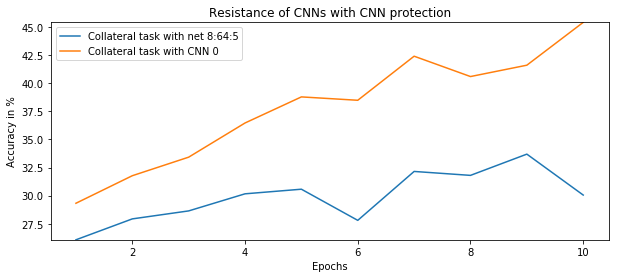

In [36]:
architectures = [
    (
        nn.Conv2d(1, 20, 5, 1),
        nn.Conv2d(20, 50, 5, 1),
        nn.Linear(4*4*50, 500),
        nn.Linear(500, N_FONTS)
    )
]
# ,
#    (
#        nn.Conv2d(1, 30, 4, 1),
#        nn.Conv2d(30, 100, 4),
#        nn.Linear(100 * 4 * 4, 1000),
#        nn.Linear(1000, 100),
#        nn.Linear(100, N_FONTS)
#    )
for i, architecture in enumerate(architectures):
    model = CNNet(architecture, quadratic_model)
    _, test_perfs_font = evaluate_resistance(model)
    
    resistance_reports[f"Collateral task with CNN {i}"] = test_perfs_font
    
show_results(resistance_reports, title="Resistance of CNNs with CNN protection")

In [37]:
model

CNNet(
  (proj1): Linear(in_features=784, out_features=50, bias=True)
  (diag1): Linear(in_features=50, out_features=8, bias=True)
  (fc3): Linear(in_features=5, out_features=2, bias=True)
  (net_0): Linear(in_features=8, out_features=784, bias=True)
  (net_1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (net_2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (net_3): Linear(in_features=800, out_features=500, bias=True)
  (net_4): Linear(in_features=500, out_features=5, bias=True)
)

In [38]:
class Parser:
    """Parameters for the training"""
    def __init__(self):
        self.epochs = 10
        self.sabotage_epochs = 10
        self.new_adversary_epochs = 10
        self.distinguisher_epochs = 10 # <-- NEW value
        self.lr = 0.002
        self.momentum = 0.5
        self.test_batch_size = 1000
        self.batch_size = 64
        self.log_interval = 100

In [39]:
build_distinguisher(model, fonts=[3, 1])

Training set 60000 items
Testing set  10000 items
4011
Train Epoch: 1 [0/24193 (0%)]	Loss Font: 0.710670
Train Epoch: 1 [6400/24193 (26%)]	Loss Font: 0.599721
Train Epoch: 1 [12800/24193 (53%)]	Loss Font: 0.582902
Train Epoch: 1 [19200/24193 (79%)]	Loss Font: 0.493015

Test set: Accuracy Char : 0/4011 (0.00%)
          Accuracy Font : 2762/4011 (68.86%)
Train Epoch: 2 [0/24193 (0%)]	Loss Font: 0.618944
Train Epoch: 2 [6400/24193 (26%)]	Loss Font: 0.496101
Train Epoch: 2 [12800/24193 (53%)]	Loss Font: 0.472052
Train Epoch: 2 [19200/24193 (79%)]	Loss Font: 0.511809

Test set: Accuracy Char : 0/4011 (0.00%)
          Accuracy Font : 2273/4011 (56.67%)
Train Epoch: 3 [0/24193 (0%)]	Loss Font: 1.079519
Train Epoch: 3 [6400/24193 (26%)]	Loss Font: 0.594698
Train Epoch: 3 [12800/24193 (53%)]	Loss Font: 0.532026
Train Epoch: 3 [19200/24193 (79%)]	Loss Font: 0.460939

Test set: Accuracy Char : 0/4011 (0.00%)
          Accuracy Font : 2727/4011 (67.99%)
Train Epoch: 4 [0/24193 (0%)]	Loss Font: 0

In [40]:
test_distinguish(model, test_dataset)

Acc 50.7 %


In [43]:
for i in range(5):
    build_distinguisher(model, fonts=[3, 1])

Training set 60000 items
Testing set  10000 items
4011
Train Epoch: 1 [0/24193 (0%)]	Loss Font: 0.643014
Train Epoch: 1 [6400/24193 (26%)]	Loss Font: 0.441344
Train Epoch: 1 [12800/24193 (53%)]	Loss Font: 0.405427
Train Epoch: 1 [19200/24193 (79%)]	Loss Font: 0.459519

Test set: Accuracy Char : 0/4011 (0.00%)
          Accuracy Font : 2672/4011 (66.62%)
Train Epoch: 2 [0/24193 (0%)]	Loss Font: 0.607927
Train Epoch: 2 [6400/24193 (26%)]	Loss Font: 0.418238
Train Epoch: 2 [12800/24193 (53%)]	Loss Font: 0.449528
Train Epoch: 2 [19200/24193 (79%)]	Loss Font: 0.467358

Test set: Accuracy Char : 0/4011 (0.00%)
          Accuracy Font : 2834/4011 (70.66%)
Train Epoch: 3 [0/24193 (0%)]	Loss Font: 0.721551
Train Epoch: 3 [6400/24193 (26%)]	Loss Font: 0.538588
Train Epoch: 3 [12800/24193 (53%)]	Loss Font: 0.477092
Train Epoch: 3 [19200/24193 (79%)]	Loss Font: 0.366764

Test set: Accuracy Char : 0/4011 (0.00%)
          Accuracy Font : 2460/4011 (61.33%)
Train Epoch: 4 [0/24193 (0%)]	Loss Font: 0


Test set: Accuracy Char : 0/4011 (0.00%)
          Accuracy Font : 3126/4011 (77.94%)
Train Epoch: 8 [0/24193 (0%)]	Loss Font: 0.417663
Train Epoch: 8 [6400/24193 (26%)]	Loss Font: 0.430060
Train Epoch: 8 [12800/24193 (53%)]	Loss Font: 0.414274
Train Epoch: 8 [19200/24193 (79%)]	Loss Font: 0.397500

Test set: Accuracy Char : 0/4011 (0.00%)
          Accuracy Font : 3075/4011 (76.66%)
Train Epoch: 9 [0/24193 (0%)]	Loss Font: 0.732956
Train Epoch: 9 [6400/24193 (26%)]	Loss Font: 0.355868
Train Epoch: 9 [12800/24193 (53%)]	Loss Font: 0.499894
Train Epoch: 9 [19200/24193 (79%)]	Loss Font: 0.342668

Test set: Accuracy Char : 0/4011 (0.00%)
          Accuracy Font : 3189/4011 (79.51%)
Train Epoch: 10 [0/24193 (0%)]	Loss Font: 0.369421
Train Epoch: 10 [6400/24193 (26%)]	Loss Font: 0.427791
Train Epoch: 10 [12800/24193 (53%)]	Loss Font: 0.280567
Train Epoch: 10 [19200/24193 (79%)]	Loss Font: 0.469689

Test set: Accuracy Char : 0/4011 (0.00%)
          Accuracy Font : 3171/4011 (79.06%)
Traini

In [44]:
test_distinguish(model, test_dataset)

Acc 77.6 %


## Summary

As this shows, if you let the distinguisher enough time to train, it becomes very performant with over 75% accuracy for the FFN and over 77% for the CNN. Notice here that the FFN has been given a total 200 epochs while the CNN had only 50, which explains why the difference is not that important.

Part 19 bis give an analysis in the case where the resistance has been made on more epochs.